# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

In [1]:
from copy import deepcopy
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple
from collections import Counter, OrderedDict
from matplotlib import pyplot as plt

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

In [2]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/home/adrien/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /home/adrien/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /home/adrien/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

In [3]:
tokenizer = get_tokenizer("basic_english", language="en")
counter = Counter([word for row in train_df["text"] for word in row.split()])
sorted_items = sorted(counter.items(), key=lambda item: item[1], reverse=True)
ordered = OrderedDict(sorted_items)
vocabulary = vocab(ordered, min_freq=5, specials=["<unk>", "<pad>"])
vocabulary.set_default_index(vocabulary["<unk>"])
len(vocabulary)

42465

In [4]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor([vocabulary[token] for token in tokenizer(text)], dtype=torch.long)

In [5]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

In [6]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X), batch_size):
        batch_X = X[i : i + batch_size]
        batch_y = y[i : i + batch_size]
        max_len = max([len(x) for x in batch_X])
        batch_X = torch.stack(
            [torch.nn.functional.pad(x, (0, max_len - len(x)), value=pad_id) for x in batch_X]
        )
        yield batch_X, torch.tensor(batch_y, dtype=torch.long)

In [8]:
train_gen = lambda: data_generator(X_train, y_train, vocabulary["<pad>"])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary["<pad>"])
test_gen = lambda: data_generator(X_test, y_test, vocabulary["<pad>"])

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [9]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [39]:
batch_size = 32
epoch = 10

In [40]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [41]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """

    # Initialize losses.
    train_losses = []
    valid_losses = []
    best_model = None
    best_loss = float("inf")

    for epoch in tqdm(range(n_epochs)):
        # Training.
        model.train()
        train_loss = 0.0
        for X, y in train_gen():
            X, y = X.to(device), y.to(device)
            # Forward pass.
            y_pred = model(X)
            # Loss computation.
            loss = criterion(y_pred, y.unsqueeze(1).float())
            # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Update train loss.
            train_loss += loss.item() * X.size(0)
        # Update training loss.
        train_loss /= len(X_train)
        train_losses.append(train_loss)

        # Validation.
        model.eval()
        valid_loss = 0.0
        for X, y in valid_gen():
            X, y = X.to(device), y.to(device)
            # Forward pass.
            y_pred = model(X)
            # Loss computation.
            loss = criterion(y_pred, y.unsqueeze(1).float())
            # Update validation loss.
            valid_loss += loss.item() * X.size(0)
        # Update validation loss.
        valid_loss /= len(X_valid)
        valid_losses.append(valid_loss)

        # Save the best model so far.
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model = deepcopy(model.state_dict())

        # Print training loss and validation loss.
        print(f"[{epoch+1}/{n_epochs}] train loss: {train_loss:.3f} - valid loss: {valid_loss:.3f}")

    # Load the best model.
    model.load_state_dict(best_model)

    return model, train_losses, valid_losses

In [42]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [43]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, epoch, train_gen, valid_gen)

  0%|          | 0/10 [00:00<?, ?it/s]

[1/10] train loss: 0.695 - valid loss: 0.694
[2/10] train loss: 0.694 - valid loss: 0.693
[3/10] train loss: 0.693 - valid loss: 0.694
[4/10] train loss: 0.695 - valid loss: 0.694
[5/10] train loss: 0.695 - valid loss: 0.694
[6/10] train loss: 0.695 - valid loss: 0.693
[7/10] train loss: 0.695 - valid loss: 0.694
[8/10] train loss: 0.694 - valid loss: 0.693
[9/10] train loss: 0.694 - valid loss: 0.695
[10/10] train loss: 0.694 - valid loss: 0.697


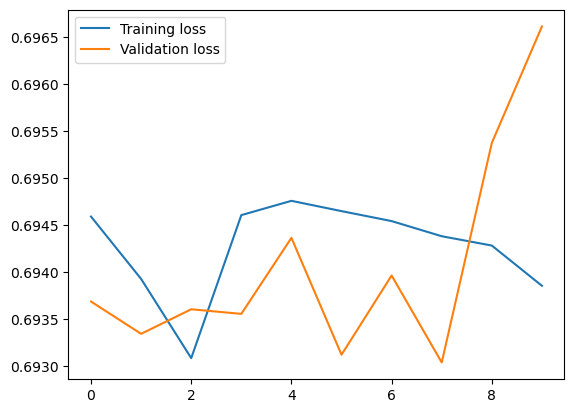

In [44]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## 2cd part (5 points)

* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.

In [45]:
def accuracy(
        model: nn.Module,
        data_gen: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
        device: str,
) -> float:
    """
    Compute the accuracy of a model.
    Args:
        model: a PyTorch Module.
        data_gen: a generator returning batches.
        device: the device to run the computation on.
    Returns:
        The accuracy of the model on the data from the generator.
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in data_gen():
            # Transfer X and y to the specified device
            X, y = X.to(device), y.to(device)

            # Call the model on X and get outputs on the same device as the model
            outputs = model(X)

            # Apply sigmoid and round to get class predictions, ensuring their on the same device as y
            predictions = torch.round(torch.sigmoid(outputs)).squeeze(1).to(device)  # to get the class prediction

            # Compute the number of correct predictions
            correct += (predictions == y).sum().item()

            # Keep track of the total number of predictions
            total += y.size(0)

    # Compute and return accuracy
    return correct / total


In [47]:
train_accuracy = accuracy(best_model, train_gen, device=device)
valid_accuracy = accuracy(best_model, valid_gen, device=device)
test_accuracy = accuracy(best_model, test_gen, device=device)
print(f'RNN Accuracy of the training set: {train_accuracy}')
print(f'RNN Accuracy of the validation set: {valid_accuracy}')
print(f'RNN Accuracy of the test set: {test_accuracy}')

RNN Accuracy of the training set: 0.50065
RNN Accuracy of the validation set: 0.5
RNN Accuracy of the test set: 0.50024


* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.

Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

In [ ]:
epoch_lstm = 3

In [48]:
class LSTM(nn.Module):
    def __init__(self, vocabulary_size: int, embedding_size: int, hidden_size: int, output_size: int = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])
        return output

In [49]:
lstm_model = LSTM(len(vocabulary), 32, 64, 1).to(device)
lstm_criterion = nn.BCEWithLogitsLoss()
lstm_optimizer = torch.optim.Adam(model.parameters())

In [50]:
best_lstm_model, train_lstm_losses, valid_lstm_losses = train(lstm_model, lstm_criterion,
                                                              lstm_optimizer, epoch_lstm, train_gen, valid_gen)

  0%|          | 0/20 [00:00<?, ?it/s]

[1/20] train loss: 0.699 - valid loss: 0.699
[2/20] train loss: 0.699 - valid loss: 0.699
[3/20] train loss: 0.699 - valid loss: 0.699
[4/20] train loss: 0.699 - valid loss: 0.699
[5/20] train loss: 0.699 - valid loss: 0.699
[6/20] train loss: 0.699 - valid loss: 0.699
[7/20] train loss: 0.699 - valid loss: 0.699
[8/20] train loss: 0.699 - valid loss: 0.699
[9/20] train loss: 0.699 - valid loss: 0.699
[10/20] train loss: 0.699 - valid loss: 0.699
[11/20] train loss: 0.699 - valid loss: 0.699
[12/20] train loss: 0.699 - valid loss: 0.699
[13/20] train loss: 0.699 - valid loss: 0.699
[14/20] train loss: 0.699 - valid loss: 0.699
[15/20] train loss: 0.699 - valid loss: 0.698
[16/20] train loss: 0.699 - valid loss: 0.699
[17/20] train loss: 0.699 - valid loss: 0.699
[18/20] train loss: 0.699 - valid loss: 0.699
[19/20] train loss: 0.699 - valid loss: 0.699
[20/20] train loss: 0.699 - valid loss: 0.699


In [52]:
train_accuracy = accuracy(best_lstm_model, train_gen, device=device)
valid_accuracy = accuracy(best_lstm_model, valid_gen, device=device)
test_accuracy = accuracy(best_lstm_model, test_gen, device=device)

print(f'LSTM Accuracy of the training set: {train_accuracy}')
print(f'LSTM Accuracy of the validation set: {valid_accuracy}')
print(f'LSTM Accuracy of the test set: {test_accuracy}')

LSTM Accuracy of the training set: 0.50005
LSTM Accuracy of the validation set: 0.5002
LSTM Accuracy of the test set: 0.50004


* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.

The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).

In [53]:
def predict(text: str, model: nn.Module, vocab: Vocab, device: str = "cpu") -> Tuple[int, float]:
    """
    Predict the class of a text string.
    Args:
        text: a text string.
        model: a PyTorch model.
        vocab: a torchtext.vocab.Vocab object.
        device: a string ("cpu" or "cuda").
    Returns:
        The predicted class (0 or 1) and its confidence (a float between 0 and 1).
    """
    model.to(device)
    model.eval()

    tokenized_text = tokenizer(text)
    numericalized_text = [vocab[token] for token in tokenized_text]
    tensor_text = torch.LongTensor(numericalized_text).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(tensor_text)
        output_prob = torch.sigmoid(output).item()
        predicted_class = 1 if output_prob > 0.5 else 0
        return predicted_class, output_prob

In [54]:
predict(test_df['text'][0], best_lstm_model, vocabulary)

(1, 0.540716826915741)

* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.

Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.

In [60]:
epoch_bilstm = 3

In [61]:
class BiLSTM(nn.Module):
    def __init__(self, vocabulary_size: int, embedding_size: int, hidden_size: int, output_size: int = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        forward_hidden = hidden[-2,:,:]
        backward_hidden = hidden[-1,:,:]
        hidden = torch.cat((forward_hidden, backward_hidden), dim=1)
        output = self.fc(hidden)
        return output

In [62]:
bilstm_model = BiLSTM(len(vocabulary), 32, 64, 1).to(device)
bilstm_criterion = nn.BCEWithLogitsLoss()
bilstm_optimizer = torch.optim.Adam(model.parameters())

In [63]:
bilstm_model, bilstm_lstm_losses, valid_bilstm_losses = train(bilstm_model, bilstm_criterion,
                                                              bilstm_optimizer, epoch_bilstm, train_gen, valid_gen)

  0%|          | 0/3 [00:00<?, ?it/s]

[1/3] train loss: 0.693 - valid loss: 0.693
[2/3] train loss: 0.693 - valid loss: 0.693
[3/3] train loss: 0.693 - valid loss: 0.693


In [64]:
train_accuracy = accuracy(bilstm_model, train_gen, device=device)
valid_accuracy = accuracy(bilstm_model, valid_gen, device=device)
test_accuracy = accuracy(bilstm_model, test_gen, device=device)

print(f'LSTM Accuracy of the training set: {train_accuracy}')
print(f'LSTM Accuracy of the validation set: {valid_accuracy}')
print(f'LSTM Accuracy of the test set: {test_accuracy}')

LSTM Accuracy of the training set: 0.5062
LSTM Accuracy of the validation set: 0.4972
LSTM Accuracy of the test set: 0.50444


* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.

In [58]:
model.eval()
misclassified_examples = []
with torch.no_grad():
    for X, y in test_gen():
        X, y = X.to(device), y.to(device)

        outputs = model(X).to(device)
        predictions = torch.round(torch.sigmoid(outputs)).squeeze(1)
        misclassified_indices = (predictions != y).nonzero().flatten()
        for i in misclassified_indices:
            misclassified_examples.append((X[i], y[i], predictions[i]))
        if len(misclassified_examples) >= 2:
            break

In [59]:
misclassified_examples[0], misclassified_examples[1]

((tensor([  145,   277,     2,   286,  7106,     5,    11,    21,     2,     0,
            255,  2566,   430,    38,   664,    12,  4153,     2,  1501,   430,
              2,   138,    14,     3,   109,  1993,   430,    72,     7,     3,
           5737,     8,     2,  3353,    42,    33,     0,   410,   631,   623,
              4,   145,     0, 21573, 25034,   175,   375,   430,     2,    20,
              7,    42,     3,   198,   369,  1531,     8,     0,  1371,   422,
              8, 26408,   623,   145, 15528, 21573, 25034,    98,     2,    20,
              0,  2556,   430,     2,   369,    39,    33,  4841,     4,     0,
              0,  1161,   143,     4,     7,  4184,    30,     3, 12363,  1765,
              5,  4153,   430,     2,  2078,   571,     3,   601,     5,  4153,
             10, 15528, 21573, 25034,   559,  2328,   623,     4,  3712,    74,
              3,  1093,    16,     2, 20424,   430,     3,   432,   601,     5,
              0,   906,    75,   650,   

* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.